# Information Pursuit: A Wikispeedia Analysis

This notebook developes an in-depth analysis of the `Wikispeedia` dataset. The goal is to identify the characteristics of human navigation paths, and use this knowledge to produce useful insights on how to assess the difficulty of arbitrary pairs of articles, and the downfalls of common human strategies.

This study requires advanced inspection of the Wikispeedia network of pages, and the results collected from multiple thousand games.

This notebook is divided into four main parts:
1. Wikispeedia network analysis
2. Path Efficiency Analysis
3. Navigation Strategies

In [1]:
%load_ext autoreload
%autoreload 2

### Understanding the data

Before stepping into the analysis, we first describe briefly the data at hand. This also allows us to show a few transformations that have been done to ease data manipulation.

Load and transform some data to make it easy to use

In [2]:
from src.utils.data import load_graph_data

graph_data = load_graph_data()

2024-12-20 16:50:24,343 - src.utils - INFO - loading raw data from tsv files...
2024-12-20 16:50:24,529 - src.utils - INFO - formatting articles...
2024-12-20 16:50:24,530 - src.utils - INFO - formatting categories...
2024-12-20 16:50:24,532 - src.utils - INFO - formatting links...
2024-12-20 16:50:24,571 - src.utils - INFO - formatting paths...
2024-12-20 16:50:24,719 - src.utils - INFO - formatting distance matrix...
2024-12-20 16:50:26,495 - src.utils - INFO - converting distance matrix to dataframe...
2024-12-20 16:50:29,200 - src.utils - INFO - building graph...


In [3]:
from src.utils import describe_dict

describe_dict(graph_data)

Keyword                       | Type (shape)          
------------------------------------------------------
shortest-path-distance-matrix   DataFrame (319476, 1) 
paths_finished                  DataFrame (51318, 9)  
articles                        DataFrame (4604, 1)   
paths_unfinished                DataFrame (24875, 9)  
links                           DataFrame (119882, 2) 
categories                      DataFrame (5204, 2)   
graph                           DiGraph (4604, 119944)
target_median_duration          DataFrame (3997, 3)   
top_200_hubs                    List (200)            


### Why analysing human behaviors

In [ ]:
from src.utils.analyzers.human_behavior_analyzer import game_stats_comparison_df

# Show differences between paths and shortest paths

paths_info = game_stats_comparison_df(graph_data)

paths_info

path_length                             \
                                          count       mean       std   min   
source       target                                                          
10th_century 11th_century                   3.0   2.000000  0.000000   2.0   
             Country                        1.0   3.000000       NaN   3.0   
14th_century African_slave_trade            3.0   7.333333  2.081666   5.0   
             Elizabeth_I_of_England         4.0   7.500000  5.744563   4.0   
             Fire                           1.0   4.000000       NaN   4.0   
...                                         ...        ...       ...   ...   
Zirconium    Hebrew_calendar                1.0   5.000000       NaN   5.0   
             Magna_Carta                    1.0   4.000000       NaN   4.0   
             Robinson_Crusoe                1.0  10.000000       NaN  10.0   
             United_Kingdom                 1.0   4.000000       NaN   4.0   
             Ununbium                       1.0   3.000000       NaN   3.0   

                                                            shortest_distance  
                                      25%   50%   75%   max                    
source       target                                                            
10th_century 11th_century             2.0   2.0   2.0   2.0               1.0  
             Country                  3.0   3.0   3.0   3.0               2.0  
14th_century African_slave_trade      6.5   8.0   8.5   9.0               3.0  
             Elizabeth_I_of_England   4.0   5.0   8.5  16.0               2.0  
             Fire                     4.0   4.0   4.0   4.0               3.0  
...                                   ...   ...   ...   ...               ...  
Zirconium    Hebrew_calendar          5.0   5.0   5.0   5.0               3.0  
             Magna_Carta              4.0   4.0   4.0   4.0               3.0  
             Robinson_Crusoe         10.0  10.0  10.0  10.0               4.0  
             United_Kingdom           4.0   4.0   4.0   4.0               2.0  
             Ununbium                 3.0   3.0   3.0   3.0               2.0  

[5585 rows x 9 columns]

In [ ]:
from src.utils.analyzers.human_behavior_analyzer import game_stats_simple_join

# Show differences between paths and shortest paths

stats = game_stats_simple_join(graph_data)
stats

,optimal_path_length,source,target,path_length
49,3.0,14th_century,African_slave_trade,5.0
50,3.0,14th_century,African_slave_trade,8.0
51,3.0,14th_century,African_slave_trade,9.0
57,2.0,14th_century,Greece,4.0
59,3.0,14th_century,John_F._Kennedy,7.0
...,...,...,...,...
41027,3.0,Star_Trek__Deep_Space_Nine,Full_moon,4.0
41021,3.0,Star_Trek__Deep_Space_Nine,Agnosticism,6.0
41024,3.0,Star_Trek__Deep_Space_Nine,Eldfell,6.0
27204,3.0,Liberal_democracy,Osmium,7.0


In [ ]:
from src.utils.analyzers.human_behavior_analyzer import game_stats_survival_plot

game_stats_survival_plot(stats)

In [ ]:
from scipy import stats

print(stats.pearsonr(paths_info[("path_length", "mean")], paths_info["shortest_distance"]))

PearsonRResult(statistic=0.48137486194062207, pvalue=5.93e-322)


## Wikispeedia network analysis

We will start our work by analyzing the Wikispeedia graph.

For this, we create a graph of the wikispeedia game where:
- Each node in the graph represents an article
- A directed edge (u, v) exists if there is a hyperlink from article u to article v.
- The weight of an edge (u, v) represents the number of times users navigated from article u to article v.


First, we start by analyzing the main hubs of the wikipedia network. We use the networkx hits function for that.

In [ ]:
graph_data["top_200_hubs"][:10]

[('United_States', 0.03200700973556944),
 ('Europe', 0.014288514610421112),
 ('United_Kingdom', 0.013541183870019555),
 ('England', 0.011879911089967285),
 ('Africa', 0.009278435436513601),
 ('Earth', 0.007903973698874068),
 ('World_War_II', 0.007684152102499427),
 ('North_America', 0.0059824357619878005),
 ('Germany', 0.005739168103755113),
 ('France', 0.005580619685426554)]

Now we want to analyze how often users click on the provided hyperlinks

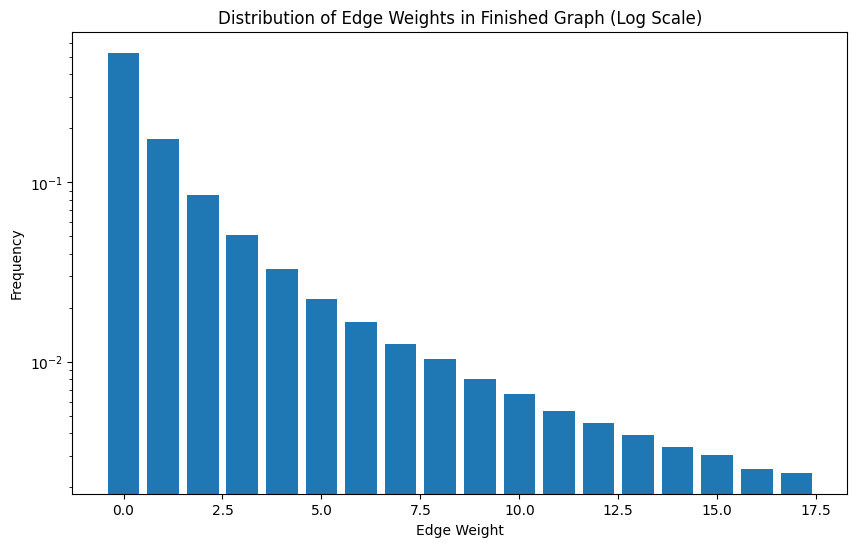

{0: 0.5272043620356166, 1: 0.17350596945241112, 2: 0.08539818582004936, 3: 0.051057160008003734, 4: 0.032865337157340094}


In [ ]:
from matplotlib import pyplot as plt

# Extract edge weights
weights = [data["weight"] for _, _, data in graph_data["graph"].edges(data=True)]
num_edges = len(weights)
frequencies = {w: weights.count(w) / num_edges for w in set(weights)}

# Cut off the tail for better visualization
cutoff = 0.0023
filtered_frequencies = {k: v for k, v in frequencies.items() if v >= cutoff}

# Plot filtered_frequencies with log scale
plt.figure(figsize=(10, 6))
plt.bar(filtered_frequencies.keys(), filtered_frequencies.values())
plt.xlabel("Edge Weight")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Edge Weights in Finished Graph (Log Scale)")
plt.show()

# Print only the first 5 frequencies
print(dict(list(frequencies.items())[:5]))

As we can see in the above graph, 52% of the hyperlinks were never clicked by any user, 17% of the hyperlinks were clicked only once and 8% of the hyperlinks were clicked twice. Let's take a closer look at that.

Below are the 20 most clicked hyperlinks by any user

In [ ]:
import pandas as pd

edges = [(u, v, data["weight"]) for u, v, data in graph_data["graph"].edges.data()]
edges = pd.DataFrame(edges, columns=["from", "to", "weight"]).sort_values("weight", ascending=False).reset_index(drop=True)
edges[:20]

,from,to,weight
0,Brain,Computer_science,681
1,Animal,Mammal,652
2,North_America,United_States,651
3,Europe,United_Kingdom,600
4,Communication,Telephone,539
5,United_States,President_of_the_United_States,528
6,Lion,Zebra,474
7,Mammal,Zebra,470
8,United_Kingdom,England,463
9,England,Europe,456


Now we will analyze the in-degree of the articles. 

The in-degree of an article is the number of hyperlinks pointing towards that article

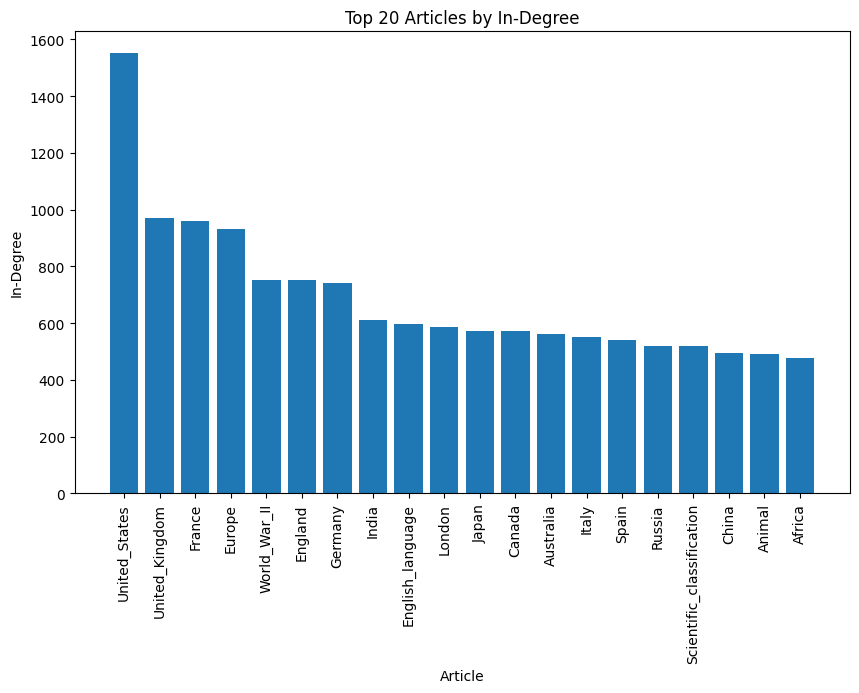

In [ ]:
in_degrees = pd.DataFrame(graph_data["graph"].in_degree, columns=["article", "inDegree"])
in_degrees_sorted = in_degrees.sort_values("inDegree", ascending=False).head(n=20)

plt.figure(figsize=(10, 6))
plt.bar(in_degrees_sorted["article"], in_degrees_sorted["inDegree"])
plt.xlabel("Article")
plt.ylabel("In-Degree")
plt.title("Top 20 Articles by In-Degree")
plt.xticks(rotation=90)
plt.show()

Now we will enumerate the articles with in-degree 0. There are no hyperlink pointing towards these articles and they can never be reached from another article. Those articles are also called orphan articles.

In [ ]:
in_degrees.query("inDegree == 0")

,article,inDegree
0,Áedán_mac_Gabráin,0
4,Óengus_I_of_the_Picts,0
5,€2_commemorative_coins,0
34,2005_Hertfordshire_Oil_Storage_Terminal_fire,0
36,2005_Lake_Tanganyika_earthquake,0
...,...,...
4566,Yellowhammer,0
4575,Yotsuya_Kaidan,0
4576,You're_Still_the_One,0
4580,"Yungay,_Peru",0


As we can see, there are 465 unreachable articles.

Now let us analyze the out degrees of the nodes. The out-degree of an article is the number of hyperlinks in that article.

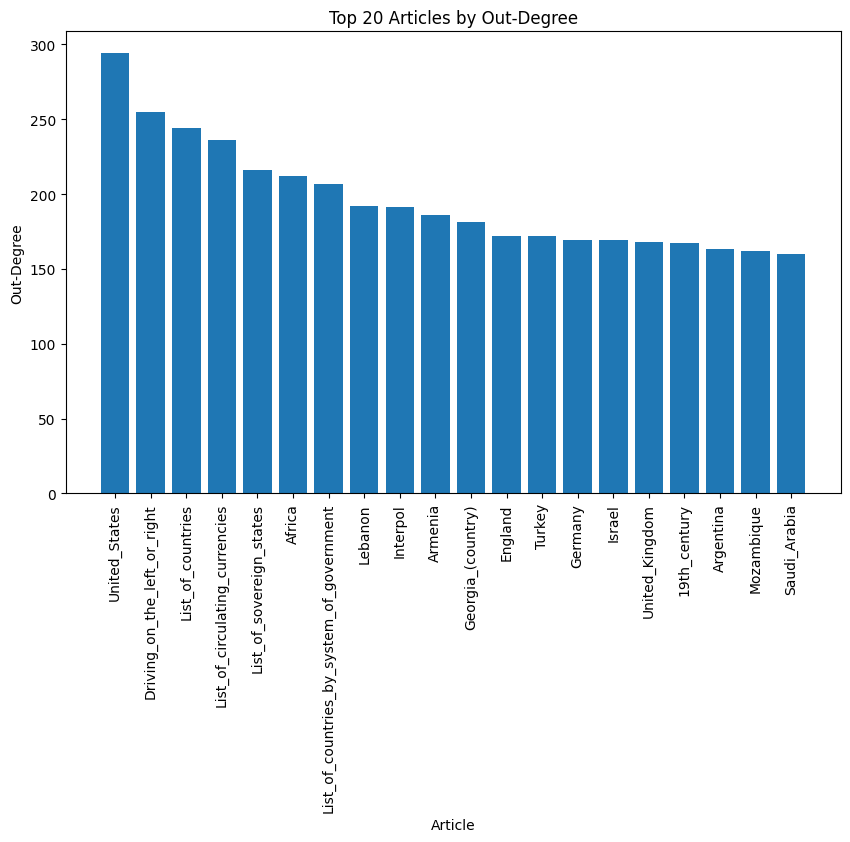

In [ ]:
out_degrees = pd.DataFrame(graph_data["graph"].out_degree, columns=["article", "outDegree"])
out_degrees_sorted = out_degrees.sort_values("outDegree", ascending=False).head(n=20)

plt.figure(figsize=(10, 6))
plt.bar(out_degrees_sorted["article"], out_degrees_sorted["outDegree"])
plt.xlabel("Article")
plt.ylabel("Out-Degree")
plt.title("Top 20 Articles by Out-Degree")
plt.xticks(rotation=90)
plt.show()

In [ ]:
out_degrees.query("outDegree == 0")

,article,outDegree
441,Badugi,0
970,Color_Graphics_Adapter,0
1210,Directdebit,0
1231,Donation,0
1237,Douglas_DC-4,0
1257,Duchenne_muscular_dystrophy,0
2351,Klinefelter's_syndrome,0
2530,Local_community,0
2543,Lone_Wolf_(gamebooks),0
3108,Osteomalacia,0


There are no node with out-degree 0. Every article has at least one hyperlink in it.

##### Community Detection

It can be interesting to explore how articles are connected to each other. Community analysis is a powerful tool for uncovering hidden structures in the Wikipedia graph, revealing what group of articles form communities, i.e. group of nodes that are densely connected internally. For that, we use the Leiden algorithm, a community-detection algorithm that works well for huge directed graph.

The detected communities can also help us further analyze players' behaviors by studying how they navigate across communities.

In [ ]:
import leidenalg
import igraph as ig

communities = leidenalg.find_partition(
	ig.Graph.from_networkx(graph_data["graph"]), leidenalg.RBConfigurationVertexPartition, n_iterations=20, seed=5
)
node_names = {i: node for i, node in enumerate(graph_data["graph"].nodes())}
for i, community in enumerate(communities):
	if len(community) > 5:
		print(f"Community {i}, {len(community)}: {[node_names[node] for node in community]}")

Community 0, 885: ['Åland', 'Édouard_Manet', '€2_commemorative_coins', '10th_century', '11th_century', '12th_century', '13th_century', '14th_century', '15th_century', '16th_century', '1755_Lisbon_earthquake', '17th_century', '1896_Summer_Olympics', '18th_century', '19th_century', '1st_century', '1st_century_BC', '20th_century', '2nd_century', '3rd_century', '4th_century', '5th_century', '6th_century', '7th_century', '8th_century', '9th_century', 'A_Wrinkle_in_Time', 'A_cappella', 'Aachen', 'Aarhus', 'Abkhazia', 'Able_Archer_83', 'Abraham_Goldfaden', 'Abstract_art', 'Accountancy', 'Achilles', 'Achilles_tendon', 'Actuary', 'Adam_Smith', 'Adolf_Hitler', 'Adriaen_van_der_Donck', 'Aesthetics', 'Agamemnon', 'Age_of_Enlightenment', 'Agnosticism', 'Akhenaten', 'Albigensian_Crusade', 'Albrecht_Dürer', 'Albrecht_Rodenbach', 'Alcibiades', 'Aleksandr_Pushkin', 'Aleksandr_Vasilevsky', 'Aleksey_Arakcheyev', 'Alexander_the_Great', 'Alfred_Nobel', 'Allegory_in_the_Middle_Ages', 'Amish', 'Amsterdam', '

Below are the detected communities:
- Community 0 - **Europe 🇪🇺**. This community includes articles related to European countries, cities, landmarks, and notable figures.
- Community 1 - **Biology 🌱**. Comprising articles on animals, plants, and various natural sciences.
- Community 2 - **Americas 🌎**. This community covers a wide range of topics related to the american continent, including countries, historical events, presidents, and prominent figures.
- Community 3 - **Africa and Asia 🌍**. This community contains articles about countries, history, and cultures across Africa, Asia, and South America.
- Community 4 - **United Kingdom 🇬🇧**. Articles within this community delve into British history, culture, politics, notable figures, and cities.
- Community 5 - **Astronomy, chemistry, physics and maths ⚛️**. This community brings together articles on celestial bodies, the periodic table and physics and maths.
- Community 6 - **Computer Science 🤖**. Our favorite one, here we can find articles about programming languages, operating systems, ...
- Community 7 - **Tennis 🥎**. A small community of 24 articles, all about Tennis.

## Path Efficiency Analysis

In this section, we conduct a Path Efficiency Analysis to evaluate various navigation strategies in the Wikispeedia network. Our objective is to understand user navigation behaviors by examining how efficiently users navigate through articles.


   - Network and Path Structure Analysis
   - Correlation between rank and path length

#### Instructions to Rerun the Code

The analysis taking quite some time to generate, we load here some precomputed data. To regenerate the data yourself, run (but pay attention need to change the paths for the generated data in the next cell): 

```bash
python3 src/scripts/generate_path_analysis.py

In [ ]:
# Loading of our analysis results and needed imports

import json
from PIL import Image

with open("data/generated/plaintext_analysis/analysis_20241115_184429/analysis_report.json", "r") as f:
	analysis = json.load(f)
with open("data/generated/plaintext_analysis/analysis_20241115_184429/path_statistics.json", "r") as f:
	path_stats = json.load(f)
with open("data/generated/plaintext_analysis/analysis_20241115_184429/statistical_results.json", "r") as f:
	stats = json.load(f)

1. Network and Path Structure Analysis

In [ ]:
# Load network metrics
network_metrics = analysis["network_analysis"]["basic_metrics"]

print("Network Structure:")
print(f"Nodes (Articles): {network_metrics['nodes']:,}")
print(f"Edges (Links): {network_metrics['edges']:,}")
print(f"Network Density: {network_metrics['density']:.4f}")
print(f"Average Clustering: {network_metrics['avg_clustering']:.4f}")
print(f"Average Path Length: {network_metrics['avg_path_length']:.2f}")

Network Structure:
Nodes (Articles): 4,604
Edges (Links): 124,486
Network Density: 0.0059
Average Clustering: 0.3416
Average Path Length: 3.18


In our Wikipedia network:
- **Nodes (4,604)**: Each node represents a Wikipedia article
- **Edges (124,486)**: Each edge represents a hyperlink from one article to another
  - For example: If article "Physics" has a link to "Energy", there's an edge Physics → Energy
  - These are directed edges (A → B doesn't mean B → A exists)

- Density = actual edges / maximum possible edges
- Maximum possible edges = n * (n-1) for directed graph with n nodes
- Our density of 0.0059 means:
  - Only 0.59% of possible connections exist
  - For reference, a fully connected network would have density = 1
  - This sparsity is typical for real-world networks

- Finally, clustering measures how well articles' neighbors are connected to eachother. 0.3416 means about 34% of possible connections between neighbors exist, which indicates articles tend to form well connected local groups, and also demonstrates some sort of topical clustering (related articles link to eachother)
- The average path length is 3.18 demonstrating how many articles hops were needed until finishing a path

### Correlation between rank and remaining path length length

We want to determine whether players get better or worse as they progress within a single game, where better means finding the target in the least possible amount of clicks.
To explain our method, let's consider two hypothetical games:
- The first game is from `Bird` to `Sun`.
- The second game is from `Telephone` to `Sun`, but at some during the game, the player visits the article `Bird`.
In which of the two games will the player reach `Sun` from `Bird` in the least amount of clicks?
Now, for all the games where the target was `Sun` and where the player visited the article `Bird` at some point during the game, do the players reach `Sun` from `Bird` slower if their encounter with `Bird` happens later in the game?

To answer this question we will perform the following computation:

For every ordered pair of distinct articles $A$ and $B$, we consider the games where $B$ is the target,
and we study the correlation between the **rank**, that is, the moment in the game where $A$ is visited,
(ignoring those games where $A$ is not visited)
and the **remaining path length** (that is, the number of clicks the player takes to reach $B$ from $A$).

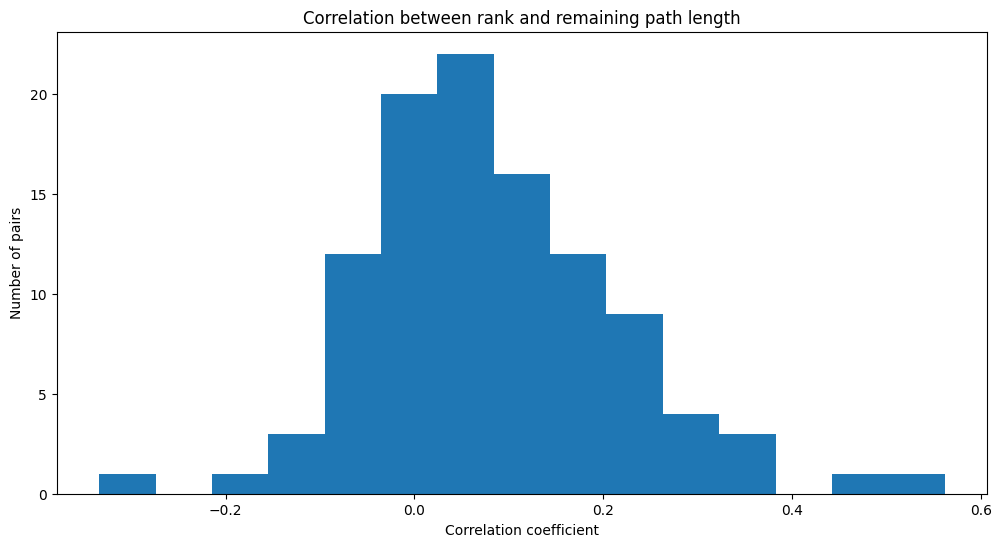

In [ ]:
from src.utils.metrics import compute_correlation_between_rank_and_path_length
import warnings

# Computing correlation coefficients yields RuntimeWarnings when the std is 0
with warnings.catch_warnings():
	warnings.simplefilter(action="ignore", category=RuntimeWarning)
	corr_data = compute_correlation_between_rank_and_path_length(graph_data["paths_finished"])


COUNT_THRESHOLD = 60  # We restrict our analysis to article pairs that have enough instances,
# otherwise the correlation coefficient will not be significant enough

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)
ax.hist(corr_data.pipe(lambda x: x[x["count"] > COUNT_THRESHOLD])["correlation_coefficient"].values, bins=15, log=False)
ax.set_title("Correlation between rank and remaining path length")
ax.set_xlabel("Correlation coefficient")
ax.set_ylabel("Number of pairs");

Although the correlation is not strong for most pairs, we see that there is a slight bias towards the positive side, meaning that the higher the rank, the longer the remaining path length.

In other words, players perform worse (maybe they get tired, or frustrated) the longer the game.

Further analysis could be made using different metrics, such as spearman's rank correlation, which works with non normal data
(it doesn't seem reasonable to assume that the distribution of the ranks is normal) and would allow us to formulate
the null hypothesis that there is relationship between rank and remaining path length.

## Navigation Strategies

It seems quite reasonable to hypothetized that humans navigate the pages of the Wikispeedia website based on relationships existing between the target article concept and the content of the articles found along the way. In order to reason about these semantic relations, humans abstract ideas and form their inner world model, making internalizing concepts efficient and smooth.

In this analysis, we verify if an intuitive top-down approach is indeed the most prevalent strategy of the players.

*Do players have a tendancy to over-utilize hubs of the Wikispeedia networks?*\
*Is this strategy usually paying-off?*

We will explore the above questions for the final report

## Hub-focused strategy

In this strategy, we hypothesize that players navigate through “hub” articles - highly connected articles that serve as navigation landmarks in the Wikspeedia network. To identify these hubs, we use PageRank, which ranks articles based on their centrality and importance in the network. Thus, using this strategy, players can access a broad set of connections and navigate closer to the target. We then analyze whether players tend to use these hub articles in their successful navigation paths. To see that there is a clear pattern of paths going through general articles, we analyze the behavior for an average path.

To quantify the extent to which players rely on hubs in their navigation paths, we define the **Hub Usage Ratio (HUR)** as follows:

$$
\text{Hub Usage Ratio (HUR)} = \frac{\text{Number of Hub Articles in the Path}}{\text{Total Number of Articles in the Path}}
$$

Where:
- **Hub Articles**: Articles in the top 200 by PageRank.
- **Path**: The sequence of articles visited by the player during navigation.

This metric allows us to evaluate the degree to which players utilize hubs in their navigation. For example:
- A **HUR of 1.0** indicates that the player's path consists entirely of hub articles.
- A **HUR of 0.0** indicates that no hub articles were used in the path.

In [98]:
from src.scripts.data_story.plots.hubs_distribution import create_pagerank_distribution_plot

create_pagerank_distribution_plot(graph_data).show()

The choice of the top 200 articles as hubs is justified by both theoretical and empirical observations. **PageRank scores in networks often follow a power-law distribution**, where a small fraction of nodes (articles, in this case) capture a disproportionately large share of the network's importance. This is clearly visible in the distribution plot, where the PageRank scores sharply decline after the top-ranked articles.

The top 200 articles (representing only 4.3% of all articles) account for 44.1% of the total PageRank score. This aligns with the **scale-free property** of networks, where a few highly connected and influential nodes dominate the network structure. These hubs serve as natural navigation location, providing efficient access to many other articles.

By selecting the top 200 articles, we balance between capturing the most influential hubs and maintaining a manageable set. Including too many articles would dilute the concept of "hub" and reduce the navigation strategy's precision.

Moreover, examining the top 5 hubs **—United States, Europe, United Kingdom, England, and Africa—** reveals that they are broad, general-knowledge topics that naturally act as checkpoints for navigation. Beyond these, the PageRank scores drop significantly (from 0.032 for United States to 0.0093 for Africa). This supports the 200-article cutoff as an optimal choice.

## Semantic search strategy

In this strategy, we assume that the player is more likely to click on articles that are semantically closer to the target article.

The key question is whether the semantic similarity between the current article and the target article increases as players progress along their path. If this similarity grows, it would suggest that the player is following the strategy of selecting more semantically related articles.

We will do the following steps to answer that question:
1. Compute the TF-IDF matrix to represent the documents as embeddings
2. Compute the cosine similarity between two embeddings to assess how similar two articles are.
3. To quantify whether semantic similarity increases over time, we will use Spearman's rank correlation. 

The Spearman's rank correlation evaluates how well the order of semantic similarity aligns with a strictly increasing sequence. The correlation score ranges from -1 to 1, with 1 indicating a perfect monotonic increase in similarity. 

We will refer to this score as the semantic_increase_score (SIS).

Let us compute the TF-IDF matrix to assess the similarity between the top 5 articles.

In [ ]:
from src.scripts.data_story.plots.semantic_strategy import similarity_matrix_figure

similarity_matrix_figure().show()

In [ ]:
from src.scripts.data_story.plots.semantic_strategy import semantic_path_example
from src.utils.strategies.semantic_strategy import semantic_increase_score

path = graph_data["paths_finished"]["path"][9876]
print(path)
fig = semantic_path_example(path)
fig.show()
print(f"SIS = {semantic_increase_score(path, path[-1])}")

['Cinema_of_the_United_States', '20th_century', 'Vitamin', 'Anemia', 'Sickle-cell_disease', 'Malaria', 'Yellow_fever', 'Virus', 'Common_cold']


SIS = (0.7380952380952381, 0.03655276105286081)


In [ ]:
from src.utils.strategies.semantic_strategy import semantic_increase_score

scores = {"paths_finished": [], "paths_unfinished": []}

for key, value in scores.items():
	print(f"Computing scores for {key}...")
	for i, row in graph_data[key].iterrows():
		score, p_value = semantic_increase_score(row["path"], row["target"])
		if p_value < 0.99:  # Ignore scores that are not statistically significant
			value.append(score)

Computing scores for paths_finished...
Computing scores for paths_unfinished...


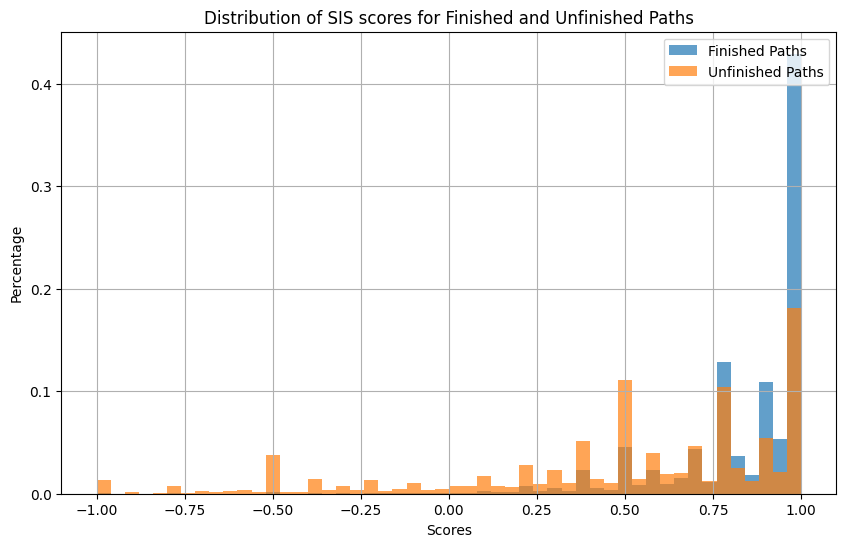

In [ ]:
# Plot histogram for paths_finished and paths_unfinished on the same graph
plt.figure(figsize=(10, 6))
plt.hist(
	scores["paths_finished"],
	bins=50,
	weights=[1 / len(scores["paths_finished"])] * len(scores["paths_finished"]),
	alpha=0.7,
	label="Finished Paths",
)
plt.hist(
	scores["paths_unfinished"],
	bins=50,
	weights=[1 / len(scores["paths_unfinished"])] * len(scores["paths_unfinished"]),
	alpha=0.7,
	label="Unfinished Paths",
)
plt.xlabel("Scores")
plt.ylabel("Percentage")
plt.title("Distribution of SIS scores for Finished and Unfinished Paths")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

## Backtrack strategy

The **Backtrack Strategy** aims to quantify exploratory behavior in navigation paths by analyzing how frequently players revisit previously visited nodes (backtracking). This behavior is measured using the **Backtrack Ratio (BR)**.

The Backtrack Ratio (BR) is defined as:

$$
BR = \frac{\text{Number of Backtrack Steps in Path}}{\text{Total Number of Steps in Path}}
$$

Where:
- **Backtrack Steps**: Moves represented by `<` in the path.
- **Total Steps**: All moves in the path, including backtracks.

In [7]:
from src.scripts.data_story.plots.backtrack_distribution import create_backtrack_analysis_plot

create_backtrack_analysis_plot(graph_data).show()

The distribution of backtrack ratios reveals insights into player navigation strategies:

1. **Limited Backtracking**:
   - Most paths have very low backtrack ratios, with a significant spike at \( BR = 0 \), indicating players largely prefer forward navigation.

2. **Finished vs. Unfinished Navigation**:
   - **Finished Paths** (67.4%): Tend to cluster around BR = 0 with a lower mean backtrack ratio (green dashed line), reflecting more efficient navigation.
   - **Unfinished Paths** (32.6%): Spread across higher BR values, with a higher mean backtrack ratio (red dashed line), indicating more exploratory behavior.

# Strategy : how to find unrelated specific articles

The game sometimes contains some totally unrelated articles that have no direct links. One human strategy would be to find use more general concepts to bridge these two articles.
For example when browsing from Picasso to Theory of Relativity, it might be easier to go from Picasso to Spain, even if Spain is not closer to Theory of Relativity. Because Spain is a more general article, it might be easier to find a link to Science for example.

To test this hypothesis we first link the articles to their pagerank scores, which we normalize.
After that we will plot the average path and how the generality of the articles behave.

In [ ]:
from src.utils.data import load_graph_data
from src.utils.metrics import pagerank

# Load the data
paths_finished = graph_data["paths_finished"]

graph_pagerank = pagerank(graph_data["graph"])

In [ ]:
article_gen_score = graph_pagerank.set_index("Article")["Generality_score"]

# Get path finished and filter so that we only keep short paths (other are noise)
paths_finished = graph_data["paths_finished"]
paths_finished = paths_finished[paths_finished["path"].apply(len) <= 20]
# Remove < from path (but keep the articles that the person attempted to go to)
paths_finished["path"] = paths_finished["path"].apply(lambda x: [u for u in x if u != "<"])


paths_finished["Generality_score"] = paths_finished["path"].apply(lambda path: article_gen_score.loc[path].tolist())

/tmp/ipykernel_34617/3330500446.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished['path'] = paths_finished['path'].apply(lambda x: [u for u in x if u != '<'])
/tmp/ipykernel_34617/3330500446.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_finished['Generality_score'] = paths_finished['path'].apply(


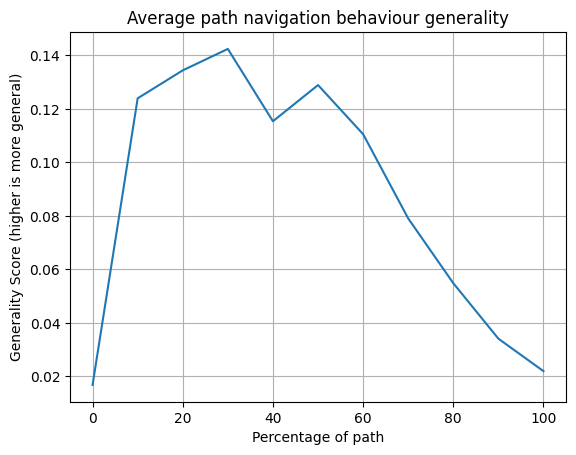

In [ ]:
from utils.metrics import average_path

scores, percent = average_path(10, paths_finished)


plt.plot(percent, scores)
plt.xlabel("Percentage of path")
plt.ylabel("Generality Score (higher is more general)")
plt.title("Average path navigation behaviour generality")
plt.grid(True)
plt.show()

We see that on average, while the first and last articles are very specific, the middle articles are more general, confirming our hypothesis.
We also see that there is a decrease in generality towards the end when the player probably has a specific path in mind of how to join that article

## Link position strategy

Because the players are playing under time pressure, we assume they don't have time to look at the whole articles before making a selection. Therefore we state the hypothesis that players are clicking mostly on the first links that appear on the page.
The links are ordered lexicographically so we need to scan the html files to find the order of the links. Then we will normalize by the number of links on the page and look at the proportion of clicks that happen with the top 20% of links (so for example if there are 20 links on a given page, a click would count towards that quantity if it is on the first 4 links.)


In [ ]:
from src.utils.data import get_links_from_html_files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
all_links_dict = get_links_from_html_files()
for article, links in all_links_dict.items():
	for link in links:
		# Normalize to get relative position
		link["position"] = link["position"] / len(links)

starting...


In [ ]:
from utils.strategies.link_strategy import get_click_positions

paths_finished = graph_data["paths_finished"]
paths_unfinished = graph_data["paths_unfinished"]

click_positions_fin = get_click_positions(paths_finished)
click_positions_unfin = get_click_positions(paths_unfinished)

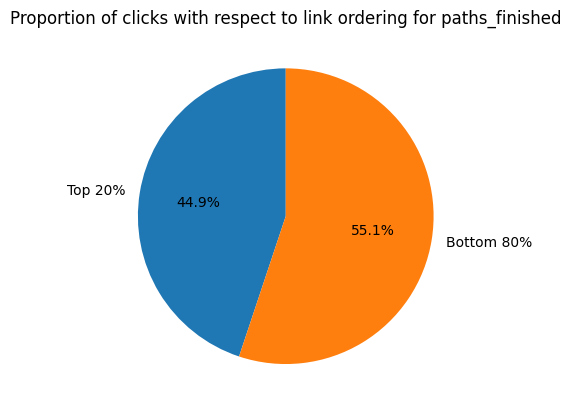

In [ ]:
top_links = [pos for pos in click_positions_fin if pos <= 0.2]
otherlinks = [pos for pos in click_positions_fin if pos > 0.2]


labels = ["Top 20%", "Bottom 80%"]
sizes = [len(top_links), len(otherlinks)]

# Plot results as a pie with percentage, to add precision change x.2f
plt.pie(sizes, labels=labels, autopct=lambda x: f"{x:.1f}%", startangle=90)
plt.title("Proportion of clicks with respect to link ordering for paths_finished")
plt.show()

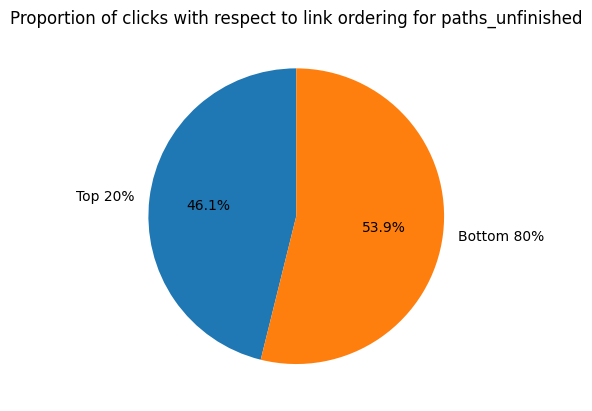

In [ ]:
top_links = [pos for pos in click_positions_unfin if pos <= 0.2]
otherlinks = [pos for pos in click_positions_unfin if pos > 0.2]

labels = ["Top 20%", "Bottom 80%"]
sizes = [len(top_links), len(otherlinks)]

# Plot results as a pie with percentage, to add precision change x.2f
plt.pie(sizes, labels=labels, autopct=lambda x: f"{x:.1f}%", startangle=90)
plt.title("Proportion of clicks with respect to link ordering for paths_unfinished")
plt.show()

It appears that both paths that are finished and unfinished click mostly on links in the top of the page (45% instead of expected 20% if the players scanned the whole page and articles importance was disseminated at random.) So players employ this strategy that is not reflected in the shortest path matrix since it doesn't take into account the position of the links. Note that the slightly higher percentage of top clicks in paths_unfinished may mean that unsuccessful players are more naive, but this hypothesis needs to be tested more in detail because the difference is so small.


## Conclusion

This analysis of the Wikispeedia dataset has provided valuable insights into human navigation behaviors and the structural properties of the Wikispeedia network. By examining the network's characteristics, we gained a better understanding of the communities, hubs, and connections. The path efficiency analysis revealed patterns in human decision-making, while the study of navigation strategies highlighted the strengths and weaknesses of common approaches.

These findings enhance our understanding of how humans traverse information networks and offer a foundation for developing tools to predict navigation challenges and optimize user experience.